# NAO example notebook

This notebook contains an example of access of ERA5 data with the `Reader` class and evaluation of the NAO teleconnection (station based index) with `aqua` libraries and an example of the plotting routines.

In [1]:
import datetime
import sys
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from aqua import Reader
sys.path.insert(0, '../') # Hack to import from parent directory, to be removed
from index import station_based_index
from plots import index_plot, reg_plot
from tools import load_namelist

## Teleconnection details configuration

Details such as teleconnection coordinates, folder input/output are obtained with functions collected in the `tools.py` file, that access details from a `yaml` file.
The function `load_namelist` loads data specific to the choosen teleconnection such as coordinates.

Details about the NAO teleconnection can be accessed by specificing the teleconnection name as a string.
The field required to evaluate the teleconnection is also specified in the `namelist`. (WIP to be automatically fixed by the reader)

In [2]:
diagname  = 'teleconnections'
telecname = 'NAO'
exp       = 'ERA5'

namelist = load_namelist(diagname,configdir='../')

field = namelist[telecname]['field']

`namelist` contains now the detail about the teleconnections diagnostic.

In [4]:
namelist

{'ERA5': {'year1': 1979, 'year2': 2022},
 'NAO': {'field': 'msl',
  'lat1': 37.7,
  'lon1': -25.7,
  'lat2': 64.1,
  'lon2': -22},
 'NAO_lisbon': {'field': 'msl',
  'lat1': 38.7,
  'lon1': -9.1,
  'lat2': 64.1,
  'lon2': -22},
 'ENSO': {'field': 'skt', 'latN': 5, 'lonW': -170, 'latS': -5, 'lonE': -120},
 'MJO': {'field': 'ttr', 'latN': 10, 'latS': -10, 'lonW': 30, 'lonE': 200}}

## Retrieve data with the intake AQUA functionality

Data required for the NAO teleconnection are retrieved with the `Reader` class from the `AQUA` framework (see framework notebooks for a comprehensive list of examples).

In [3]:
configdir = '../../../config/'

reader = Reader(model='ERA5',exp='era5',source='monthly_inst',configdir=configdir,regrid='r100',var=field)

In [6]:
data = reader.retrieve()
data

<xarray.Dataset>
Dimensions:     (time: 516, values: 542080)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
    lat         (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    lon         (values) float64 dask.array<chunksize=(542080,), meta=np.ndarray>
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
Dimensions without coordinates: values
Data variables:
    msl         (time, values) float32 dask.array<chunksize=(1, 542080), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_edition:            1
    intake_esm_varname:      ['msl']
    history:                 2023-03-22T11:59 GRIB to CDM+CF via cfgrib-0.9.1...
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    Conventions:             CF-1.7
    GRIB_subCentre:          0
    institution:             European Centre for Medium-Range Weather Forecasts
    intake_esm_dataset_key:  128.0.avgua.surface.monthly

### Data preparation

The `Reader` returns a `Dataset`. It is needed to select the data for the desired variable and regrid before calling the library function.

In [7]:
infile = data[field]
infile = reader.regrid(infile)
infile

<xarray.DataArray 'msl' (time: 516, lat: 180, lon: 360)>
dask.array<reshape, shape=(516, 180, 360), dtype=float64, chunksize=(1, 180, 360), chunktype=numpy.ndarray>
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    step        timedelta64[ns] ...
    surface     float64 ...
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * lat         (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
Attributes: (12/22)
    GRIB_paramId:                    151
    GRIB_dataType:                   an
    GRIB_numberOfPoints:             542080
    GRIB_typeOfLevel:                surface
    GRIB_stepUnits:                  1
    GRIB_stepType:                   avgua
    ...                              ...
    GRIB_totalNumber:                0
    GRIB_units:                      Pa
    long_name:                       Mean sea level pressure
    units:                           Pa
    standard_name:                   air_pressure_at_mean_sea_level
    regridded:                       1

## Index evaluation

The NAO index can be evaluated by using the library function `station_based_index` from the `index.py` file.

The index can be evaluated with a custom rolling window to average data (standard is 3 months, here written explicitely for sake of clarity).

The function returns a `DataArray` with the timeserie of index values.

In [8]:
nao = station_based_index(infile,namelist,telecname,months_window=3)
nao

/work/bb1153/b382289/mambaforge/envs/teleconnections/lib/python3.10/site-packages/xarray/core/indexing.py:1372: PerformanceWarning: Slicing with an out-of-order index is generating 43 times more chunks
  return self.array[key]


<xarray.DataArray 'index' (time: 514)>
dask.array<getitem, shape=(514,), dtype=float64, chunksize=(3,), chunktype=numpy.ndarray>
Coordinates:
    number      (time) int64 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  * time        (time) datetime64[ns] 1979-02-01 1979-03-01 ... 2021-11-01
    step        (time) timedelta64[ns] 00:00:00 00:00:00 ... 00:00:00 00:00:00
    surface     (time) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    valid_time  (time) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
    month       (time) int64 2 3 4 5 6 7 8 9 10 11 12 ... 2 3 4 5 6 7 8 9 10 11

The timeserie can be plot with the `index_plot` function from the `plots.py` file, already with some customization in order to make a nice plot.

(<Figure size 1200x800 with 1 Axes>,
 <Axes: title={'center': 'NAO index'}, xlabel='time', ylabel='index'>)

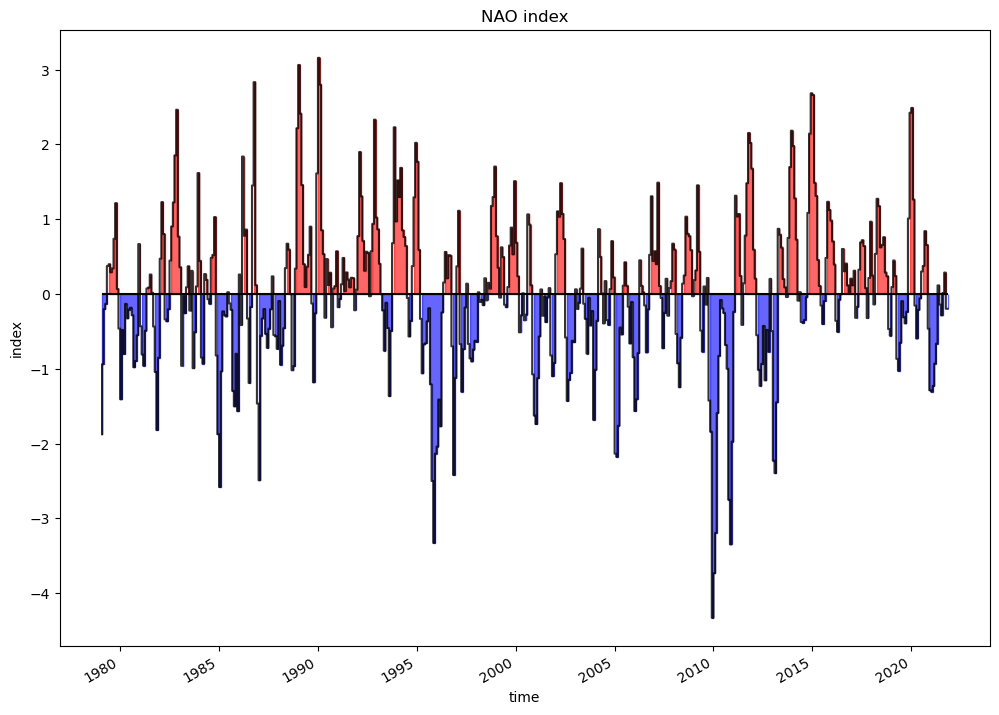

In [9]:
index_plot(nao,title='NAO index',save=True,filename='NAO_index.png',outputdir='../img/',xlabel='time')

## Regression plot

To visualize the teleconnection on a 2D plot, functions in the `plots.py` are introduced.
There is an option `plot=True` that creates a plot of the regression. Additionally an xarray containing the result of the regression is returned, if needed for further analysis or storage.
A custom projection can be specified, here the `LambertConformal` projection is used.

(<xarray.DataArray (lat: 180, lon: 360)>
 dask.array<truediv, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
 Coordinates:
   * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
   * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0,
 <Figure size 800x400 with 2 Axes>,
 <GeoAxes: title={'center': 'NAO index'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>)

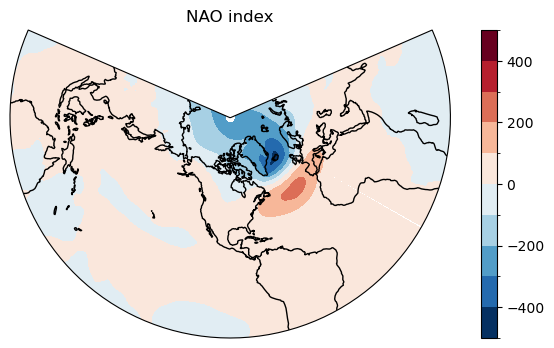

In [10]:
reg_plot(nao,infile,save=True,filename='NAO_reg.png',outputdir='../img/',projection_type='LambertConformal',
            title='NAO index',contour=True,levels=10)

## Comparison with NCAR data

With the NAO index computed, we can compare with observational data from NCAR, to check if the index is computed correctly.

In [11]:
ncar_path = '../data/nao_station_seasonal.txt'
nao_ncar = np.genfromtxt(ncar_path,skip_header=3,skip_footer=4)

In [12]:
year = nao_ncar[:,0]
month_data = nao_ncar[:, 1:]
time = xr.cftime_range(start=str(int(year[0])),periods=12*len(year),freq='MS',calendar='standard')
month_data = month_data.reshape(-1)
nao_ncar = xr.DataArray(month_data, coords=[time], dims=['time'], name='monthly_data')

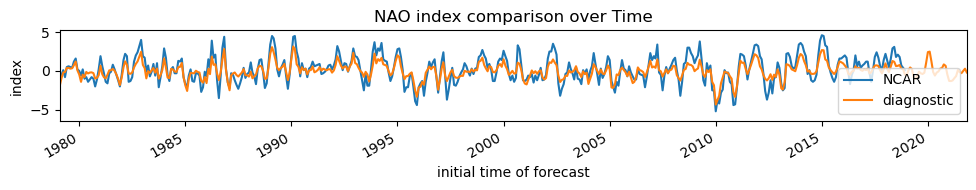

In [13]:
time_vals = np.array(time.values)

# Convert to datetime objects
datetimes = [np.datetime64(t).astype(datetime.datetime) for t in time_vals]

# Plot with matplotlib
fig = plt.figure(figsize=(10,2))
plt.plot(datetimes, nao_ncar.values,label='NCAR')

plt.xlim(datetime.datetime(1979, 1, 31, 0, 0),datetime.datetime(2021, 10, 31, 0, 0))
#plt.ylim(-5,+5)

nao.plot(label='diagnostic')
plt.legend()
plt.title('NAO index comparison over Time')
fig.tight_layout()
plt.savefig('../img/NAO_ncar.png')
plt.show()